In [2]:
from trees import Tree
from wrappers import GPTneoX_DenseWrapper, ActivationWrapper

import torch
import numpy as np
import umap
import plotly.graph_objects as go

import math
import matplotlib.pyplot as plt

/Users/collinszczepanski/Code/cris/LLM/chenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Model and Initialize Wrapper

In [3]:
model_name = "EleutherAI/pythia-1.4b-deduped"
wrapper = ActivationWrapper(model_name)

The `GPTNeoXSdpaAttention` class is deprecated in favor of simply modifying the `config._attn_implementation`attribute of the `GPTNeoXAttention` class! It will be removed in v4.48


## Identify All Tokens with Their IDs

In [4]:
vocab_dict = wrapper.get_vocab()
reversed_dict = {v: k for k, v in vocab_dict.items()}

token_id = 20344
print('Token ID', token_id, ':', reversed_dict[token_id])

Token ID 20344 : ĠFern


## Tree Generation Helpers

In [5]:
class TreeNode:
    def __init__(self, value, **attrs):
        self.value    = value
        self.attrs    = attrs       # all extra kwargs go here
        self.children = []

    def add_child(self, child):
        self.children.append(child)

    def __repr__(self, level=0):
        indent   = "  " * level
        attr_str = f" {self.attrs!r}" if self.attrs else ""
        ret = f"{indent}{self.value!r}{attr_str}\n"
        for c in self.children:
            ret += c.__repr__(level+1)
        return ret

def nodes_at_depth(root, target_depth):
    """
    Return a list of all nodes exactly target_depth below root.
    root is at depth 0.
    """
    if target_depth == 0:
        return [root]
    result = []
    for child in root.children:
        result.extend(nodes_at_depth(child, target_depth - 1))
    return result

def chunked(lst, n):
    """Yield successive n‐sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i : i + n]

def get_leaves(node):
    """
    Return a list of all leaf‐nodes in the subtree rooted at `node`.
    """
    if not node.children:
        return [node]
    leaves = []
    for child in node.children:
        leaves.extend(get_leaves(child))
    return leaves

def find_path(root, target, path=None):
    path = (path or []) + [root]
    if root is target:
        return path
    for c in root.children:
        res = find_path(c, target, path)
        if res:
            return res
    return None



## Supply a batch of inputs that root a batch of trees

In [44]:
batch = ['There are four lobes of the brain that include the', 'The', 'I went to', 'The ginko tree has leaves shaped like', 'Calcimycin is a type of']

## Top n Probs

In [25]:
# Initialize Tree
root = TreeNode("root", prob=1.0)

n = 2 #Number of Children for each node
num_gens = 10 #Depth of Tree

hold_sens = batch

# Add batch inputs as children of root
for i, sen in enumerate(batch):
    child = TreeNode(str(i), string=sen, prob = 1.0)
    root.add_child(child)


for i in range(num_gens):
    print("GEN:", i)
    working_nodes = nodes_at_depth(root, i+1)
    thing, new_sens, prob = wrapper.generate_and_prepare_top_n(hold_sens, n)
    chunks = list(chunked(new_sens, n))
    chunks2 = list(chunked(prob, n))

    for j, node in enumerate(working_nodes):
        for k, val in enumerate(chunks[j]):
            name = str(node.value) + '.' + str(j)
            child = TreeNode(name, string = val , prob= chunks2[j][k])
            node.add_child(child)

    #res, to = layer.batch_activations(thing, tokens='last', tokenized_prior=True)
    #acts.append(res.detach().numpy())

    hold_sens = new_sens

print(root)

GEN: 0
GEN: 1
GEN: 2
GEN: 3
GEN: 4
GEN: 5
GEN: 6
GEN: 7
GEN: 8
GEN: 9
'root' {'prob': 1.0}
  '0' {'string': 'There are four lobes of the brain that include the', 'prob': 1.0}
    '0.0' {'string': 'There are four lobes of the brain that include the frontal', 'prob': 0.6461859345436096}
      '0.0.0' {'string': 'There are four lobes of the brain that include the frontal,', 'prob': 0.5209523439407349}
        '0.0.0.0' {'string': 'There are four lobes of the brain that include the frontal, parietal', 'prob': 0.5737138390541077}
          '0.0.0.0.0' {'string': 'There are four lobes of the brain that include the frontal, parietal,', 'prob': 0.9587028622627258}
            '0.0.0.0.0.0' {'string': 'There are four lobes of the brain that include the frontal, parietal, temporal', 'prob': 0.8155655264854431}
              '0.0.0.0.0.0.0' {'string': 'There are four lobes of the brain that include the frontal, parietal, temporal,', 'prob': 0.5305443406105042}
                '0.0.0.0.0.0.0.0' {'

## Probabilities at Base of Tree

In [29]:
tree_top = get_leaves(root) #Obtain all sequences at maximum tree depth

tree_top_sens = []
cumulative_probs = {}

for sen in batch:
    cumulative_probs[sen] = []

for node in tree_top:
    phrase = node.attrs['string']
    tree_top_sens.append(phrase)
    path = find_path(root, node)
    path_base = path[1].attrs['string']
    print('\n')
    print('SEQUENCE:', phrase)
    prob = 1.0 
    for node2 in path:
        temp = node2.attrs.get("prob")
        prob = prob * temp
    print('CUMULATIVE PROBABILITY:', prob)
    temp = cumulative_probs[path_base]
    temp.append(prob)
    cumulative_probs[path_base] = temp



SEQUENCE: There are four lobes of the brain that include the frontal, parietal, temporal, and occipital
CUMULATIVE PROBABILITY: 0.07716188262605085


SEQUENCE: There are four lobes of the brain that include the frontal, parietal, temporal, and occipit
CUMULATIVE PROBABILITY: 0.00012661982282053018


SEQUENCE: There are four lobes of the brain that include the frontal, parietal, temporal, and occiptal
CUMULATIVE PROBABILITY: 2.6995443922936545e-05


SEQUENCE: There are four lobes of the brain that include the frontal, parietal, temporal, and occiptital
CUMULATIVE PROBABILITY: 1.939648006642775e-06


SEQUENCE: There are four lobes of the brain that include the frontal, parietal, temporal, and subcortical
CUMULATIVE PROBABILITY: 0.0005548376070797932


SEQUENCE: There are four lobes of the brain that include the frontal, parietal, temporal, and subcortex
CUMULATIVE PROBABILITY: 3.318256518235102e-06


SEQUENCE: There are four lobes of the brain that include the frontal, parietal, tempor

## Probability of Sequence Generation Up to Probability of First Token

Samples from all token probabilities at each generation step, not just from the top n most likely tokens. 

In [ ]:
cumulative_probs_all = []

for i, sen in enumerate(tree_top_sens):
    p, ids = wrapper.prob_of_generation(sen, 0.5)
    print('SEQUENCE:', sen)

    num_sens, seq_len, _ = p.shape

    gen_probs = np.zeros((num_sens, seq_len-1))

    for i in range(num_sens):
        for j in range(seq_len-1):
            gen_probs[i,j] = p[i,j, ids[i, j+1]]

    trun_probs = gen_probs[0, -num_gens:]
    mult_prob = np.prod(trun_probs)
    print(trun_probs.shape)
    cumulative_probs_all.append(mult_prob)

    print('PROBABILITIES OF GENERATION', mult_prob)
    print(cumulative_probs[i] / mult_prob)
    print('\n')


## Entropy From Top n Generation



In [34]:
def entropy(p, base=2):
    """Compute Shannon entropy of distribution p (list of floats summing to 1)."""
    log_fn = math.log if base == math.e else (lambda x: math.log(x, base))
    H = 0.0
    for pi in p:
        if pi > 0:
            H -= pi * log_fn(pi)
    return H

total_entropies = []

for key, val in cumulative_probs.items():
    total_entropies.append(entropy(val))

print(total_entropies)

[5.547802721919271, 8.352692676251555, 8.401769584361704]


## Entropy vs. Tree Depth

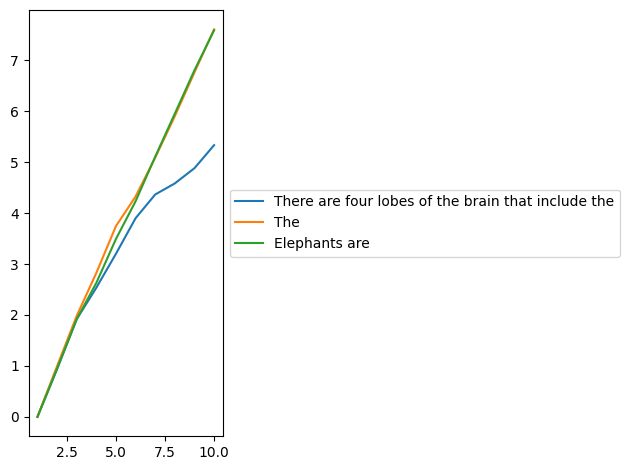

In [43]:
max_depth = num_gens + 1
entropy_vals = []

depth_probs = {}
for sen in batch:
    depth_probs[sen] = {}
    for j in range(1,max_depth):
        depth_probs[sen][j] = []

for i in range(1,max_depth):

    nodes = nodes_at_depth(root, i)
    for node in nodes:
        path = find_path(root, node)
        path_base = path[1].attrs['string']
        prob = 1.0 
        for node2 in path:
            temp = node2.attrs.get("prob")
            prob = prob * temp
        temp = depth_probs[path_base][i]
        temp.append(prob)
        depth_probs[path_base][i] = temp
    
entropies = {}
for key, d in depth_probs.items():
    temp = []
    for depth, probs in d.items():
        temp.append(entropy(probs))
    entropies[key] = temp

fig, ax = plt.subplots()
for key, val in entropies.items():
    ax.plot(range(1, max_depth), val, label=key)

# put legend to the right, centered vertically
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# make room on the right for the legend
plt.tight_layout()
plt.show()
        

# Sequential Generation Cell

In [ ]:
num_tok_samples = 1
temp = 0.5

all_to_embed = []
colors = []

num_gens = 10

hold_sens = names

acts = []

for i in range(num_gens):
    thing, new_sens, prob = wrapper.generate_and_prepare(hold_sens, num_tok_samples, temp)
    print(prob)
    res, to = layer.batch_activations(thing, tokens='last', tokenized_prior=True)
    all_to_embed.append(new_sens)
    blue = [i] * len(new_sens)
    colors.append(blue)
    hold_sens = new_sens
    acts.append(res.detach().numpy())

In [ ]:
ind = 1

acts_in_use = acts[ind]
sens_in_use = all_to_embed[ind]

In [ ]:
umapper = umap.UMAP(n_components=3)
emb = umapper.fit_transform(acts_in_use)
print(emb.shape)

x, y, z = emb[:, 0], emb[:, 1], emb[:, 2]
fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=4,
        opacity=0.8
    ),
    text=sens_in_use,
    hoverinfo='text'        
)])

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)